# Compare Python and CMSIS-DSP

In [1]:
import sys

sys.path.append('../')

import cmsisdsp as dsp
import librosa.display
import numpy as np
from matplotlib import pyplot as plt

from Pipeline.preprocess import Loader, BandpassFilter, SpectrogramExtractor, FrequencySelector, Normalizer
from Pipeline.windowing import hopping_window

In [14]:
sample_rate = 44100
loader = Loader(sample_rate=sample_rate)
bandpass = BandpassFilter(200, 20000, sample_rate)

### 1. Compare Bandpass Filtering

In [3]:
y = loader.load('../Dataset/NAU dataset/TASCAM/lab/Ponderosa/96 KHz/original_dataset/infested log longhorn/TASCAM_195.wav')

y = y[108000:108000+2205]

In [4]:
y_filtered = bandpass.filter(y)
y_filtered

array([-2.67714137e-05,  1.75547282e-04, -2.44107912e-05, ...,
       -1.40842561e-05, -1.88565611e-05,  5.89072702e-05])

In [56]:
def cmsis_bandpass(signal):
    NUM_STAGES = 2

    # second-order section (SOS) computed in Python with lowcut=200Hz and highcut=20KHz
    m_biquad_coeffs = [
        0.796954, 1.593909, 0.796954, -1.591040, -0.661705,
        1.000000, -2.000000, 1.000000, 1.959704, -0.960504
    ]

    m_biquad_state = np.zeros((NUM_STAGES, 2))

    arm_biquad_cascade_df2T_instance_f32 = dsp.arm_biquad_cascade_df2T_instance_f32()
    dsp.arm_biquad_cascade_df2T_init_f32(arm_biquad_cascade_df2T_instance_f32, NUM_STAGES, m_biquad_coeffs, m_biquad_state)

    y_filtered_cmsis = dsp.arm_biquad_cascade_df2T_f32(arm_biquad_cascade_df2T_instance_f32, signal)

    return y_filtered_cmsis

In [57]:
y_filtered_cmsis = cmsis_bandpass(y)

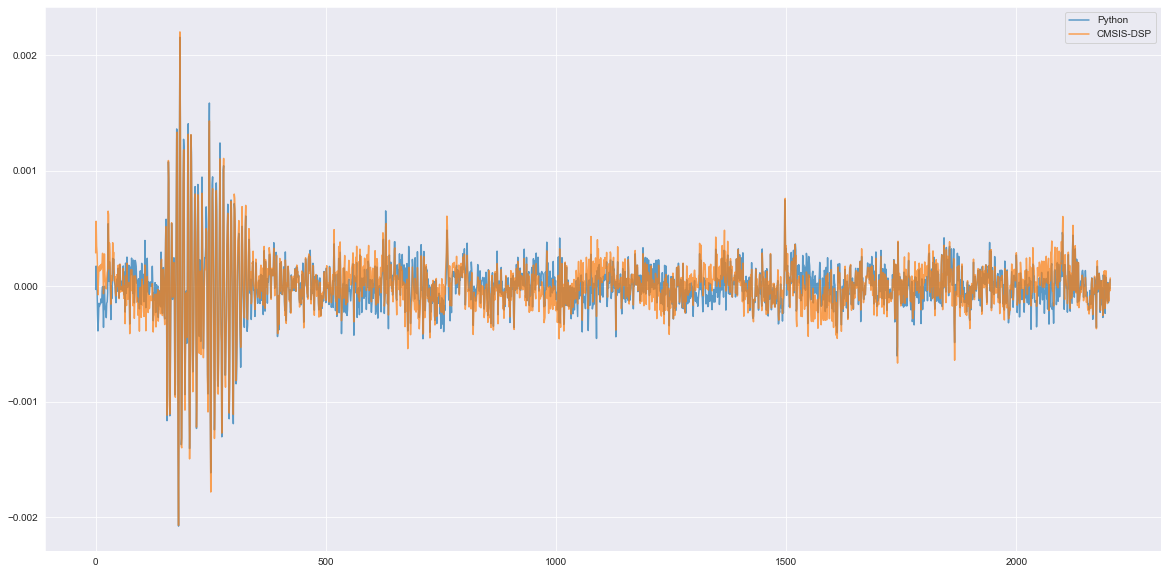

In [58]:
plt.figure(figsize=(20, 10))
plt.plot(y_filtered, label='Python', alpha=0.7)
plt.plot(y_filtered_cmsis, label='CMSIS-DSP', alpha=0.7)
plt.legend()
plt.show()

### 2. Compare Detector

In [36]:
y = loader.load('../Dataset/Generated dataset/Deployment/50ms/Background/background_1.wav')
y_filtered = bandpass.filter(y)

In [37]:
WIN_SIZE = 50
threshold = 1.36

In [38]:
std_py = []

for i in range(len(y)):
    if i >= WIN_SIZE:
        std_py.append(y_filtered[i-WIN_SIZE:i].std())

std_py = np.array(std_py)

In [39]:
std_cmsis = []

for i in range(WIN_SIZE, len(y)):
    std_cmsis.append(dsp.arm_std_f32(y_filtered[i-WIN_SIZE:i]))

std_cmsis = np.array(std_cmsis)

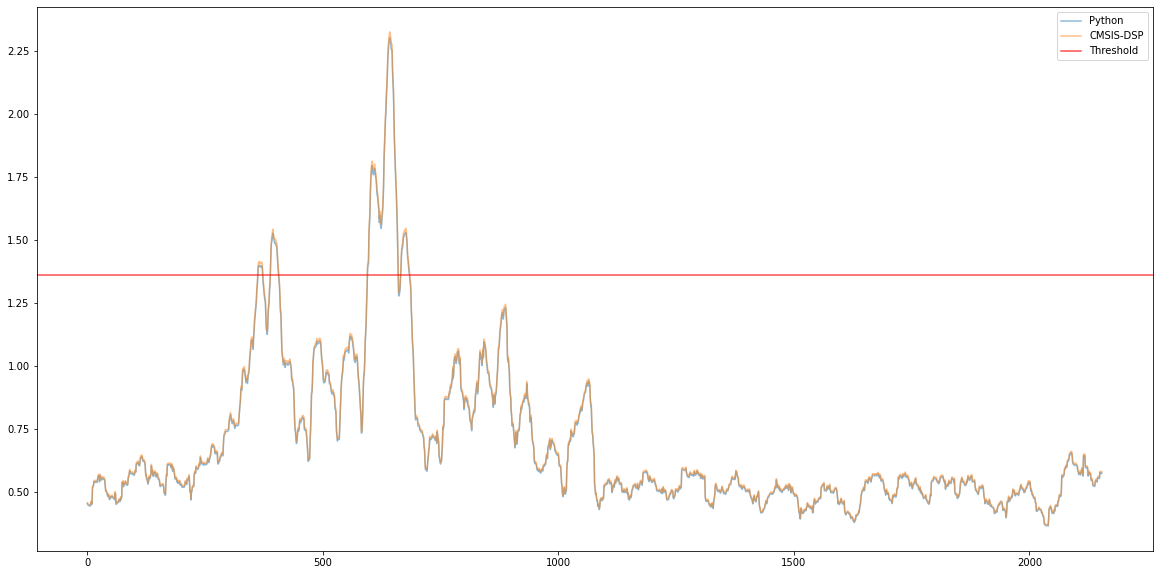

In [40]:
plt.figure(figsize=(20, 10))
plt.plot(std_py, label='Python', alpha=0.5)
plt.plot(std_cmsis, label='CMSIS-DSP', alpha=0.5)
plt.axhline(threshold, c='r', label='Threshold', alpha=0.7)
plt.legend()
plt.show()

### 3. Compare Spectrogram Extraction

In [62]:
y = loader.load("../Dataset/Generated dataset/100ms/Longhorn/longhorn_100.wav")
y = y[2205:]

In [63]:
n_fft = 128
hop_length = 64
win_length = 128
min_freq = 500
max_freq = 14000

spec_rows = int(max_freq / (sample_rate/n_fft)) - int(min_freq / (sample_rate/n_fft))
spec_cols = int(float(len(y) - win_length) / hop_length) + 1

(spec_rows, spec_cols)

(39, 33)

In [64]:
spectrogramExtractor = SpectrogramExtractor(
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
)

frequencySelector = FrequencySelector(
    min_freq=min_freq,
    max_freq=max_freq,
)

spectrogram = spectrogramExtractor.extract_spectrogram(bandpass.filter(y), log=True)
spectrogram, _ = frequencySelector.select(spectrogram, n_fft=n_fft, sample_rate=sample_rate)

In [65]:
spectrogram

array([[  9.36373849,   8.53710188,  11.74536323, ...,  -8.05188436,
          7.28165643,  -3.24432261],
       [  4.28860456,   6.54179755,   4.16932926, ...,   4.1155299 ,
         10.2037293 ,   3.36081599],
       [  6.51179492,  -1.44870264, -13.02277475, ...,   1.46271253,
          7.41245102,   6.1833049 ],
       ...,
       [  7.18636757,   1.67054938,   2.16314937, ...,  -1.34899285,
          5.69323606,   4.35157201],
       [-10.50443387,   1.86382048,   0.89386632, ...,   6.94177652,
         10.06865708,   6.68997265],
       [  1.27589525,  -1.32987752,   0.94106656, ...,   2.7274953 ,
          8.8534377 ,   8.11746189]])

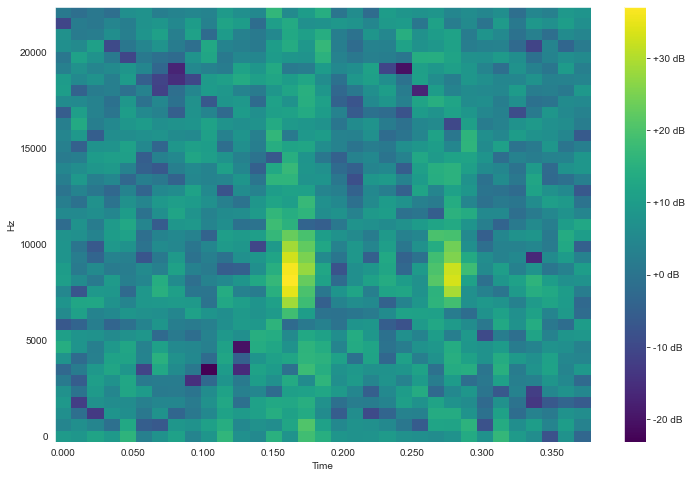

In [66]:
fig, ax = plt.subplots(figsize=(12, 8))
img = librosa.display.specshow(spectrogram, x_axis='time', y_axis='linear', sr=44100, ax=ax, cmap='viridis')
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.show()

In [67]:
rfftf32 = dsp.arm_rfft_fast_instance_f32()
status = dsp.arm_rfft_fast_init_f32(rfftf32, n_fft)

frames = hopping_window(cmsis_bandpass(y), win_length, hop_length)

In [68]:
def create_column(frame):
    frame = dsp.arm_mult_f32(frame, np.hanning(win_length))
    frame = dsp.arm_rfft_fast_f32(rfftf32, frame, 0)
    # convert to power spectrum
    result = dsp.arm_cmplx_mag_squared_f32(frame)
    # keep only relevant frequencies
    result = result[int(min_freq / (sample_rate/n_fft)):int(max_freq / (sample_rate/n_fft))]
    return result

In [69]:
spectrogram_cmsis = np.apply_along_axis(create_column, 1, frames).T
spectrogram_cmsis = librosa.power_to_db(spectrogram_cmsis)
spectrogram_cmsis

array([[  5.8918595 ,  16.462051  ,  22.690647  , ...,  10.996468  ,
          5.5653257 ,  12.689372  ],
       [  5.473818  ,   2.6489577 ,   8.704854  , ...,  -2.9374015 ,
          8.455891  ,  -1.6935915 ],
       [  3.538202  ,   7.739031  ,   5.73948   , ...,   4.880968  ,
          9.861     ,   3.6471462 ],
       ...,
       [  6.7443876 ,   5.7084723 ,  10.66699   , ...,   3.9079847 ,
         -3.6999962 ,   1.4402325 ],
       [  7.2481117 ,   1.6265049 ,   2.3665078 , ...,  -1.4435012 ,
          5.8188486 ,   4.197084  ],
       [-11.23584   ,   1.6452681 ,   0.86256117, ...,   6.953701  ,
         10.010415  ,   6.8441095 ]], dtype=float32)

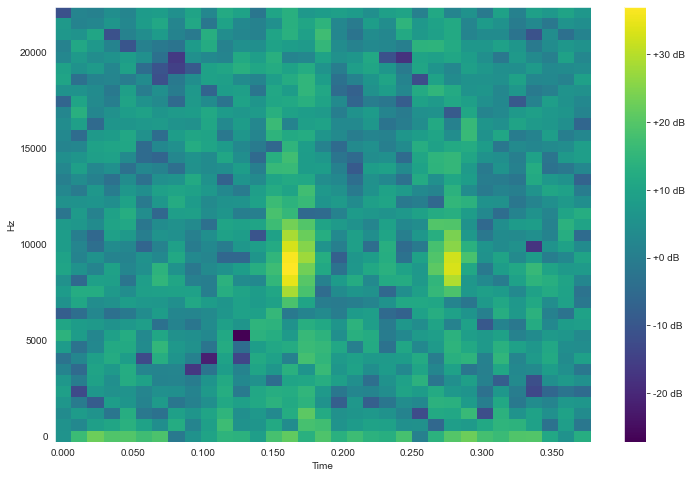

In [70]:
fig, ax = plt.subplots(figsize=(12, 8))
img = librosa.display.specshow(spectrogram_cmsis, x_axis='time', y_axis='linear', sr=44100, ax=ax, cmap='viridis')
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.show()

### 4. Compare Spectrogram Standardization

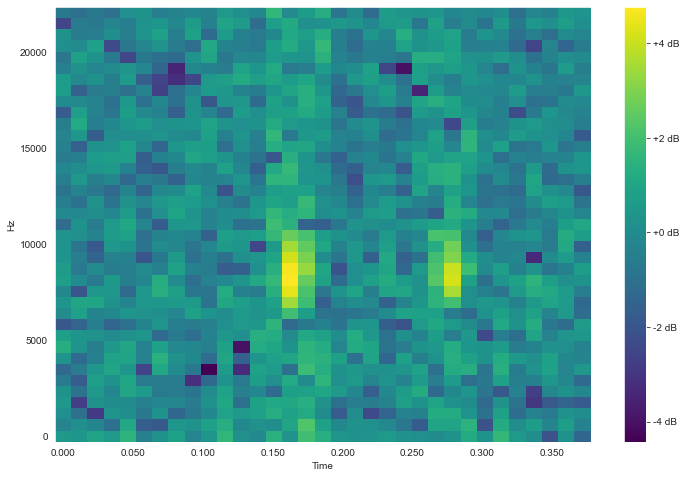

In [71]:
normalizer = Normalizer(mode='mean_std')
spectrogram_normed = normalizer.normalize(spectrogram)
fig, ax = plt.subplots(figsize=(12, 8))
img = librosa.display.specshow(spectrogram_normed, x_axis='time', y_axis='linear', sr=44100, ax=ax, cmap='viridis')
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.show()

In [72]:
def cmsis_standardize(signal):
    # Compute mean and standard deviation
    mean = dsp.arm_mean_f32(signal)
    std = dsp.arm_std_f32(signal)
    # Standardize input buffer
    signal = dsp.arm_offset_f32(signal, -mean)
    signal = dsp.arm_scale_f32(signal, (1.0 / std))

    return signal

In [73]:
# concat rows of the spectrogram to a single vector
spectrogram_cmsis_vector = np.concatenate(spectrogram_cmsis, axis=0)
spectrogram_cmsis_vector_normed = cmsis_standardize(spectrogram_cmsis_vector)

# recompose the spectrogram from the vector
cmsis_spectrogram_std_recomposed = np.split(spectrogram_cmsis_vector_normed, spec_rows)
# put everything in a matrix
cmsis_spectrogram_std_recomposed = np.vstack(cmsis_spectrogram_std_recomposed)

In [74]:
cmsis_spectrogram_std_recomposed

array([[-0.02120763,  1.547252  ,  2.4714832 , ...,  0.7362405 ,
        -0.06966041,  0.9874424 ],
       [-0.08323883, -0.5024062 ,  0.39619902, ..., -1.331339  ,
         0.35925657, -1.1467761 ],
       [-0.3704555 ,  0.2528852 , -0.0438185 , ..., -0.17120893,
         0.567754  , -0.3542898 ],
       ...,
       [ 0.10529489, -0.04841959,  0.6873509 , ..., -0.31558523,
        -1.4444968 , -0.6817631 ],
       [ 0.18004008, -0.654123  , -0.54431754, ..., -1.1096663 ,
        -0.03204137, -0.2726872 ],
       [-2.562704  , -0.6513388 , -0.7674809 , ...,  0.1363539 ,
         0.58992493,  0.12009214]], dtype=float32)

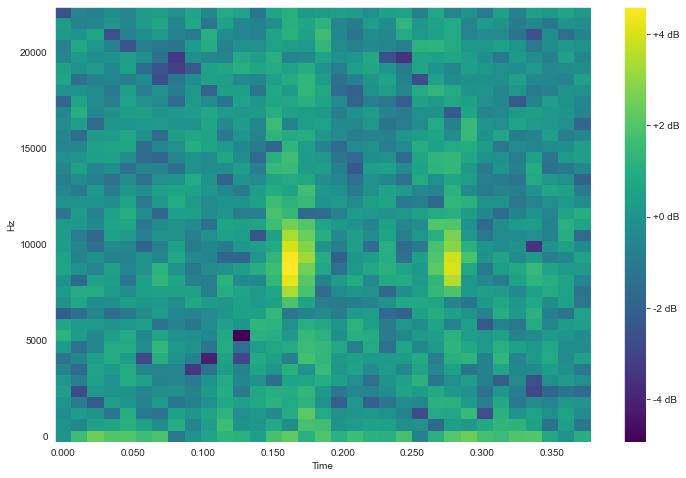

In [75]:
fig, ax = plt.subplots(figsize=(12, 8))
img = librosa.display.specshow(cmsis_spectrogram_std_recomposed, x_axis='time', y_axis='linear', sr=44100, ax=ax, cmap='viridis')
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.show()